In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score


## Dataset size
We view the size of training set, dev set, entire test set, test subset, and the 3 splits (ID, near-OOD, far-OOD).

In [2]:
def dataset_counts(dataset: str) -> None:
    base_path = Path("../data") / dataset
    counts = {}
    for split in ("train", "dev", "test"):
        df = pd.read_json(base_path / f"{dataset}-{split}.jsonl", lines=True)
        counts[split] = len(df)

    df = pd.read_json(base_path / f"{dataset}-annotations.jsonl", lines=True)
    counts["test-full"] = len(df)

    df = pd.read_json(base_path / f"{dataset}-test.jsonl", lines=True)
    total = 0
    for split in ("in", "near-ood", "far-ood"):
        split_size = (df["labels"] == split).sum().item()
        total += split_size
        counts[f"test-subset-{split}"] = split_size

    counts["test-subset"] = total
    return counts


for dataset in ("nq", "webquestions", "triviaqa"):
    counts = dataset_counts(dataset)
    print(f"{dataset}: {counts}\n")

nq: {'train': 79168, 'dev': 8757, 'test': 1940, 'test-full': 3610, 'test-subset-in': 318, 'test-subset-near-ood': 315, 'test-subset-far-ood': 1307, 'test-subset': 1940}

webquestions: {'train': 2474, 'dev': 278, 'test': 1423, 'test-full': 2032, 'test-subset-in': 271, 'test-subset-near-ood': 299, 'test-subset-far-ood': 853, 'test-subset': 1423}

triviaqa: {'train': 78785, 'dev': 8837, 'test': 3948, 'test-full': 11313, 'test-subset-in': 336, 'test-subset-near-ood': 411, 'test-subset-far-ood': 3201, 'test-subset': 3948}



## AUROC scores

In [14]:
def make_split(test_df: pd.DataFrame, pos_classes: list[str], score_type: str) -> tuple:
    mask = test_df["labels"].isin(["in", *pos_classes])
    y_true = test_df.loc[mask, "labels"].isin(pos_classes)
    y_score = test_df.loc[mask, score_type]
    return y_true, y_score


def read_baselines(base: Path, suffix: str = "baselines.jsonl") -> pd.DataFrame:
    if not (base / suffix).exists():
        return pd.DataFrame()

    test_df = pd.read_json(base / suffix, lines=True)
    results = []

    for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
        split_name = "in vs " + " + ".join(split)
        for score_type in ("mean_entropy", "max_entropy", "max_token_nll", "perplexity"):
            y_true, y_score = make_split(test_df, split, score_type)
            auroc_val = roc_auc_score(y_true, y_score)
            results.append({
                "split": split_name,
                "score_type": score_type,
                "AUROC": f"{auroc_val:.3f}",
            })

    return pd.DataFrame(results)


def read_uq_sequence(base: Path) -> pd.DataFrame:
    results = []
    for model in ("mcdropout", "flipout"):
        for metric in ("f1", "bertscore"):
            results_path = base / f"{model}-large-{metric}.jsonl"
            if not results_path.exists():
                print(f"{model}-{metric} does not exist")
                continue

            test_df = pd.read_json(results_path, lines=True)
            for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
                split_name = "in vs " + " + ".join(split)
                y_true, y_score = make_split(test_df, split, metric)

                auroc_val = roc_auc_score(y_true, y_score)
                results.append({
                    "split": split_name,
                    "score_type": f"{model}-{metric}",
                    "AUROC": f"{auroc_val:.3f}",
                })

    return pd.DataFrame(results)


def read_uq_token(base: Path):
    results = []
    for model in ("mcdropout", "flipout"):
        results_path = base / f"{model}-large-token.jsonl"
        if not results_path.exists():
            print(f"{model}-large-token.jsonl does not exist")
            continue

        test_df = pd.read_json(results_path, lines=True)
        for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
            split_name = "in vs " + " + ".join(split)
            for score_type in ("mean_mi", "max_mi"):
                y_true, y_score = make_split(test_df, split, score_type)

                auroc_val = roc_auc_score(y_true, y_score)
                results.append({
                    "split": split_name,
                    "score_type": f"{model}-{score_type}",
                    "AUROC": f"{auroc_val:.3f}",
                })

    return pd.DataFrame(results)


def compute_aurocs(dataset: str) -> None:
    base = Path("../results")
    baseline_df = read_baselines(base / dataset)
    uq_sequence_df = read_uq_sequence(base / dataset)
    uq_token_df = read_uq_token(base / dataset)

    # combined_df = pd.concat([baseline_df, uq_sequence_df]).reset_index(drop=True)

    combined_df = pd.concat([baseline_df, uq_sequence_df, uq_token_df]).reset_index(drop=True)

    combined_df["AUROC"] = combined_df["AUROC"].astype(float)           # for sorting safely

    pivot_df = combined_df.pivot_table(index="score_type", columns="split", values="AUROC")
    pivot_df = pivot_df[["in vs near-ood", "in vs far-ood", "in vs far-ood + near-ood"]]
    pivot_df.columns = ["Near", "Far", "Combined"]

    sort_order = [
        # Baselines
        "perplexity",
        "max_token_nll",
        "mean_entropy",
        "max_entropy",
        # Sequence-level
        "mcdropout-bertscore",
        "mcdropout-f1",
        "flipout-bertscore",
        "flipout-f1",
        # Token-level
        "mcdropout-mean_mi",
        "mcdropout-max_mi",
        "flipout-mean_mi",
        "flipout-max_mi",
    ]

    pivot_df = pivot_df.reindex(sort_order)

    print(f"RESULTS FOR {dataset}")
    print(pivot_df.to_latex(float_format="%.3f"))

for split in ("webquestions",):
    compute_aurocs(split)
    print("\n\n")

RESULTS FOR webquestions
\begin{tabular}{lrrr}
\toprule
 & Near & Far & Combined \\
score_type &  &  &  \\
\midrule
perplexity & 0.744 & 0.796 & 0.782 \\
max_token_nll & 0.732 & 0.793 & 0.777 \\
mean_entropy & 0.757 & 0.812 & 0.798 \\
max_entropy & 0.746 & 0.811 & 0.794 \\
mcdropout-bertscore & 0.694 & 0.777 & 0.756 \\
mcdropout-f1 & 0.733 & 0.781 & 0.768 \\
flipout-bertscore & 0.702 & 0.787 & 0.765 \\
flipout-f1 & 0.741 & 0.795 & 0.781 \\
mcdropout-mean_mi & 0.739 & 0.799 & 0.783 \\
mcdropout-max_mi & 0.724 & 0.769 & 0.757 \\
flipout-mean_mi & 0.776 & 0.853 & 0.833 \\
flipout-max_mi & 0.746 & 0.832 & 0.809 \\
\bottomrule
\end{tabular}






In [ ]:
def compute_aurocs_merged(datasets: list[str]) -> pd.DataFrame:
    base = Path("../results")
    all_dfs = []
    for dataset in datasets:
        baseline_df = read_baselines(base / dataset)
        uq_sequence_df = read_uq_sequence(base / dataset)
        uq_token_df = read_uq_token(base / dataset)
        combined_df = pd.concat([baseline_df, uq_sequence_df, uq_token_df]).reset_index(drop=True)
        combined_df["AUROC"] = combined_df["AUROC"].astype(float)
        pivot_df = combined_df.pivot_table(index="score_type", columns="split", values="AUROC")
        pivot_df = pivot_df[["in vs near-ood", "in vs far-ood", "in vs far-ood + near-ood"]]
        pivot_df.columns = pd.MultiIndex.from_product([[dataset], ["Near", "Far", "Combined"]])
        all_dfs.append(pivot_df)

    merged = pd.concat(all_dfs, axis=1)
    sort_order = [
        "perplexity", "max_token_nll", "mean_entropy", "max_entropy",
        "mcdropout-bertscore", "mcdropout-f1", "flipout-bertscore", "flipout-f1",
        "mcdropout-mean_mi", "mcdropout-max_mi", "flipout-mean_mi", "flipout-max_mi",
    ]
    return merged.reindex(sort_order)

merged_df = compute_aurocs_merged(["webquestions", "nq"])
print(merged_df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{3}{r}{webquestions} & \multicolumn{3}{r}{nq} \\
 & Near & Far & Combined & Near & Far & Combined \\
score_type &  &  &  &  &  &  \\
\midrule
perplexity & 0.744 & 0.796 & 0.782 & 0.762 & 0.796 & 0.790 \\
max_token_nll & 0.732 & 0.793 & 0.777 & 0.746 & 0.790 & 0.781 \\
mean_entropy & 0.757 & 0.812 & 0.798 & 0.778 & 0.818 & 0.810 \\
max_entropy & 0.746 & 0.811 & 0.794 & 0.760 & 0.814 & 0.803 \\
mcdropout-bertscore & 0.694 & 0.777 & 0.756 & 0.682 & 0.796 & 0.774 \\
mcdropout-f1 & 0.733 & 0.781 & 0.768 & 0.734 & 0.791 & 0.780 \\
flipout-bertscore & 0.702 & 0.787 & 0.765 & 0.705 & 0.803 & 0.784 \\
flipout-f1 & 0.741 & 0.795 & 0.781 & 0.727 & 0.780 & 0.770 \\
mcdropout-mean_mi & 0.739 & 0.800 & 0.784 & 0.768 & 0.826 & 0.815 \\
mcdropout-max_mi & 0.725 & 0.788 & 0.771 & 0.730 & 0.807 & 0.792 \\
flipout-mean_mi & 0.776 & 0.853 & 0.833 & 0.535 & 0.612 & 0.598 \\
flipout-max_mi & 0.746 & 0.832 & 0.809 & 0.530 & 0.611 & 0.595 \\
\bottomrule
\end{ta

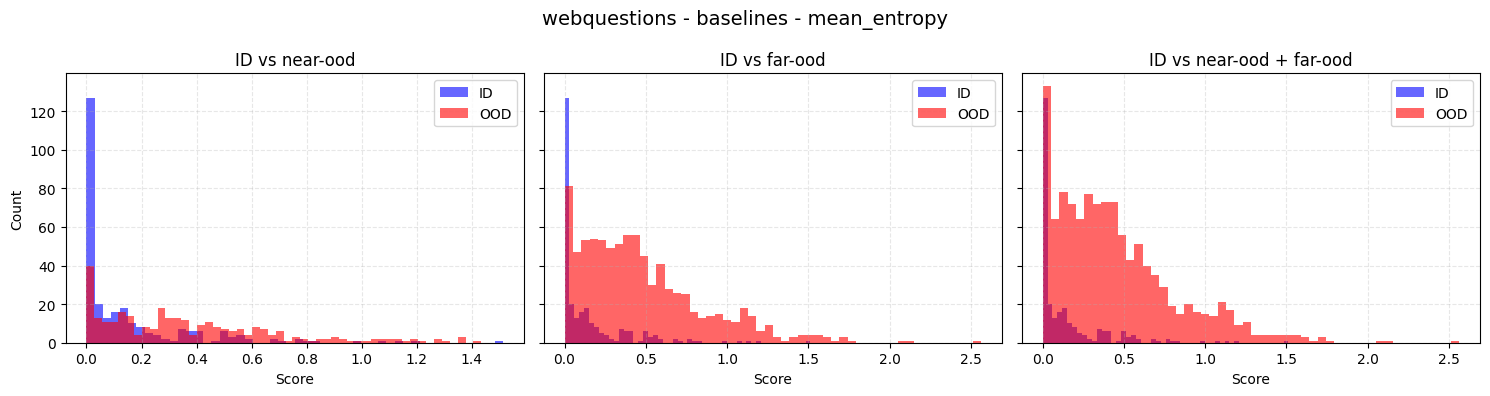

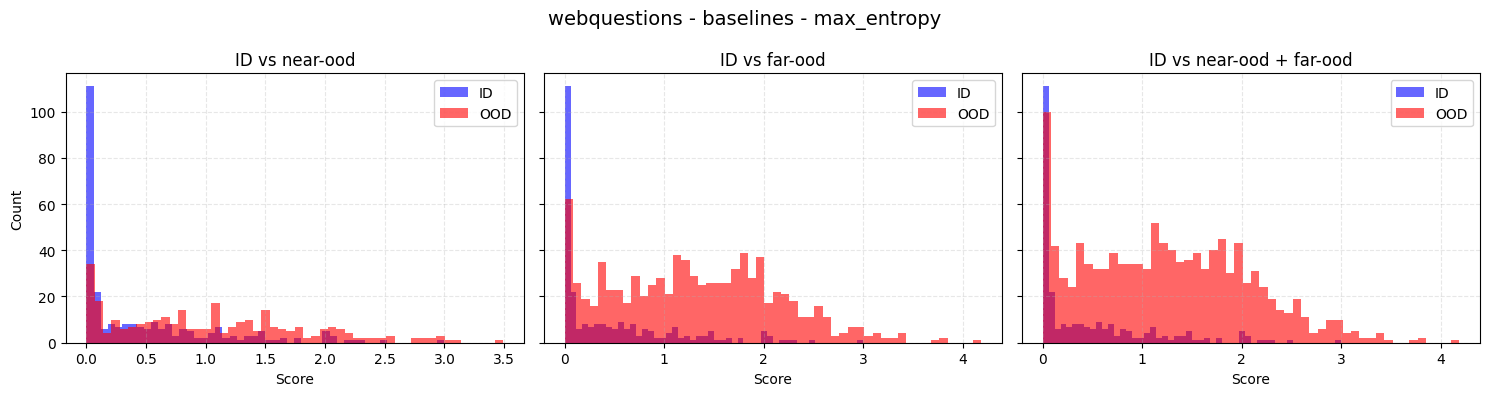

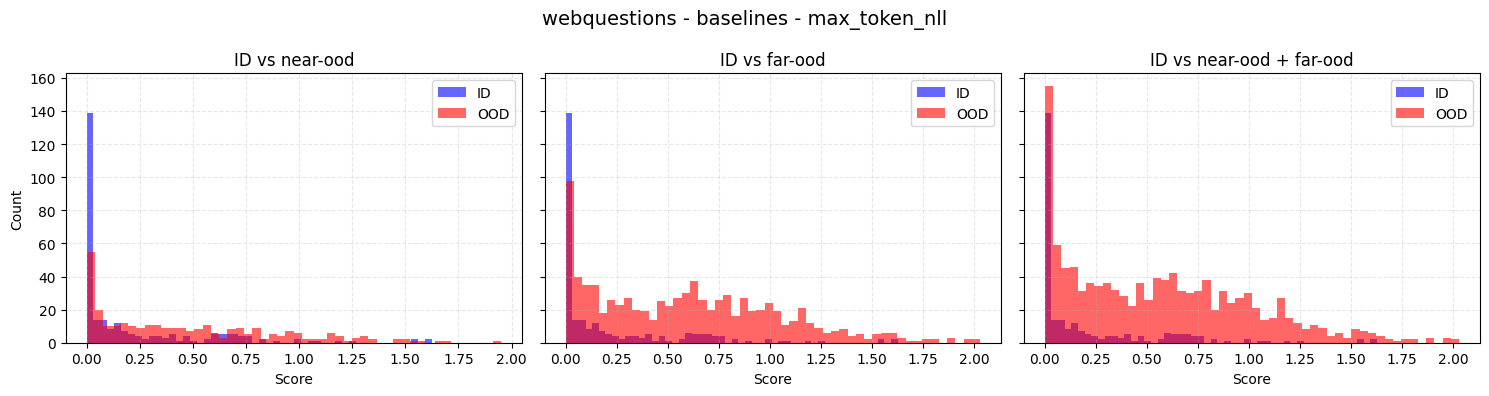

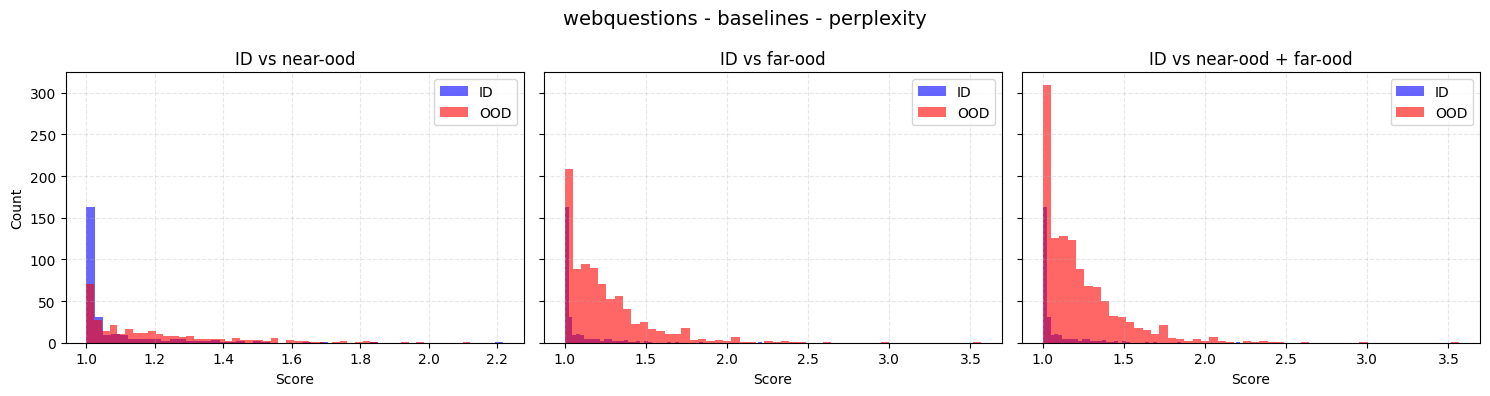

Skipping bertscore in mcdropout-large.jsonl (not found)
Skipping f1 in mcdropout-large.jsonl (not found)
Skipping bertscore in flipout-large.jsonl (not found)
Skipping f1 in flipout-large.jsonl (not found)


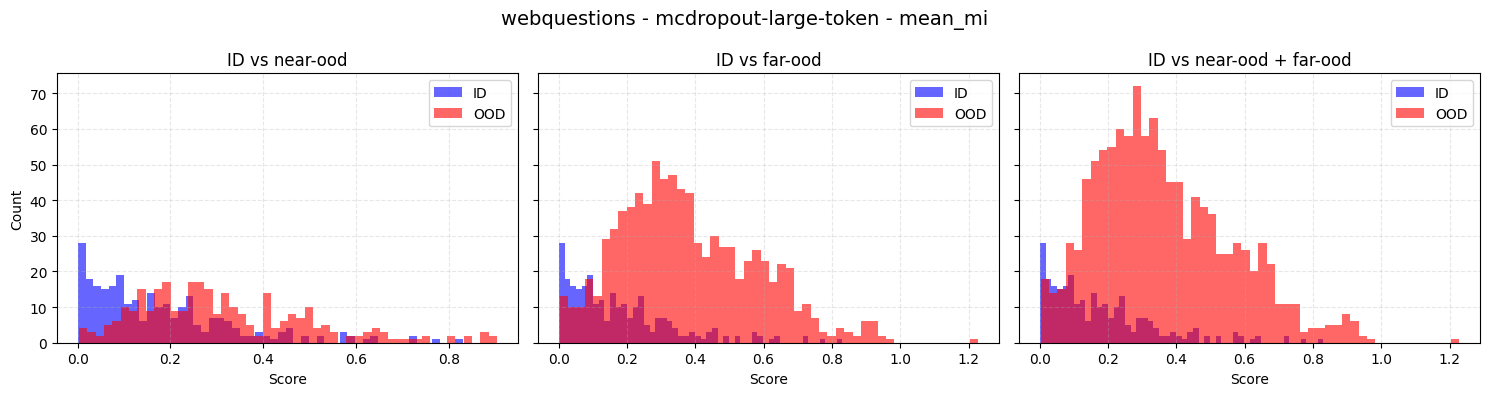

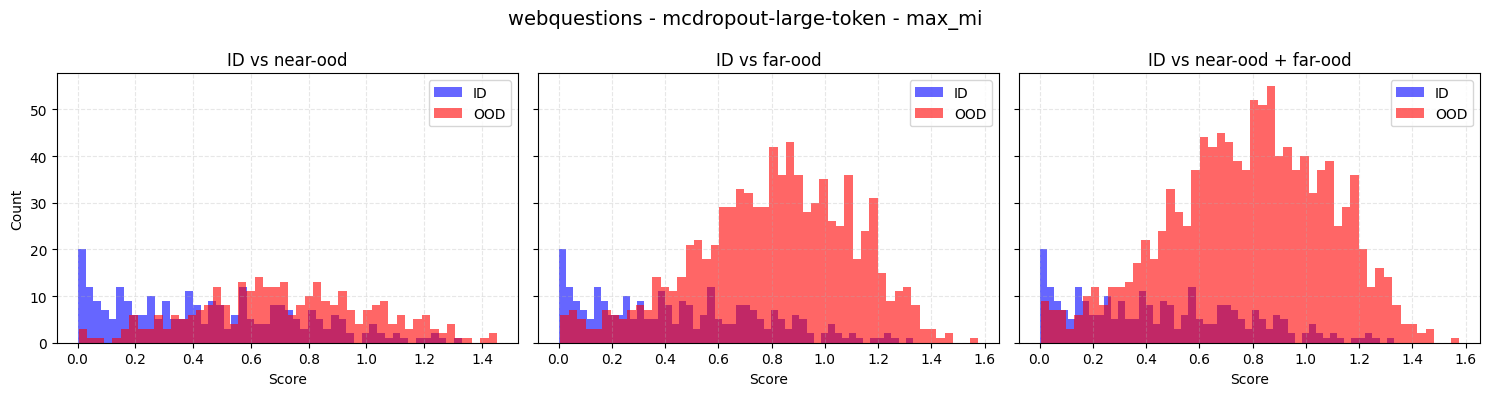

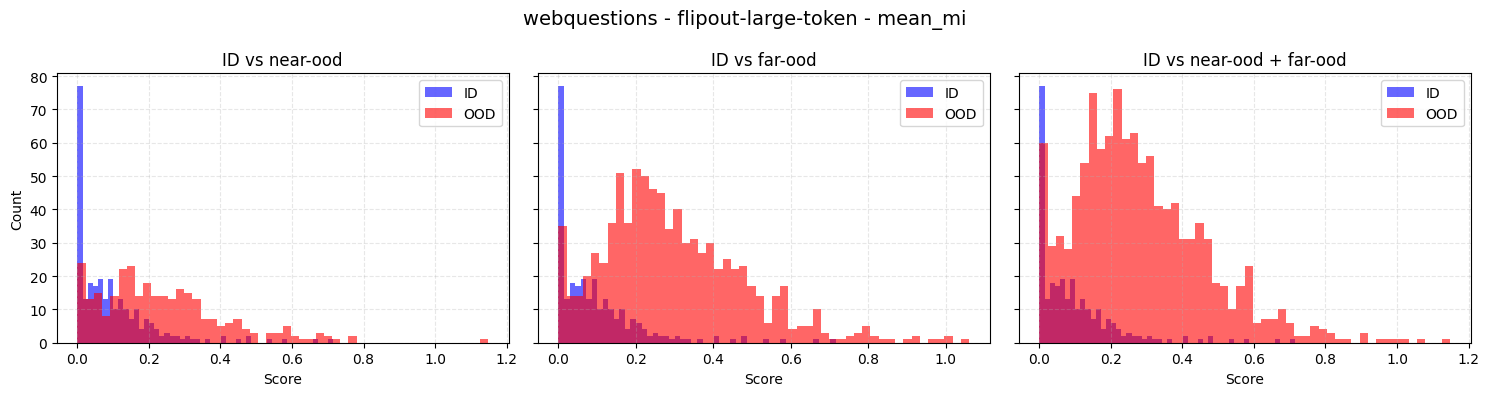

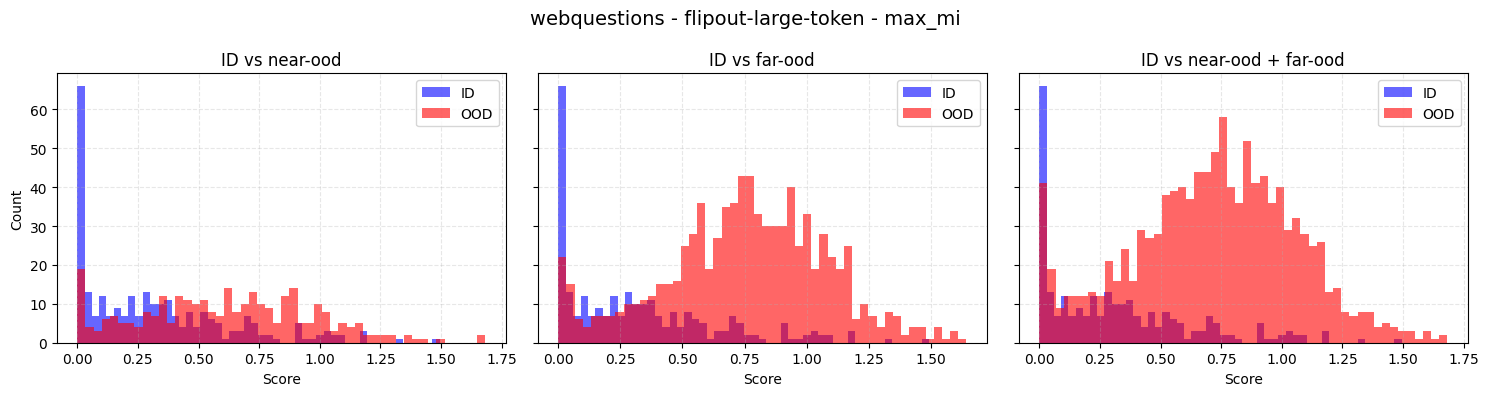

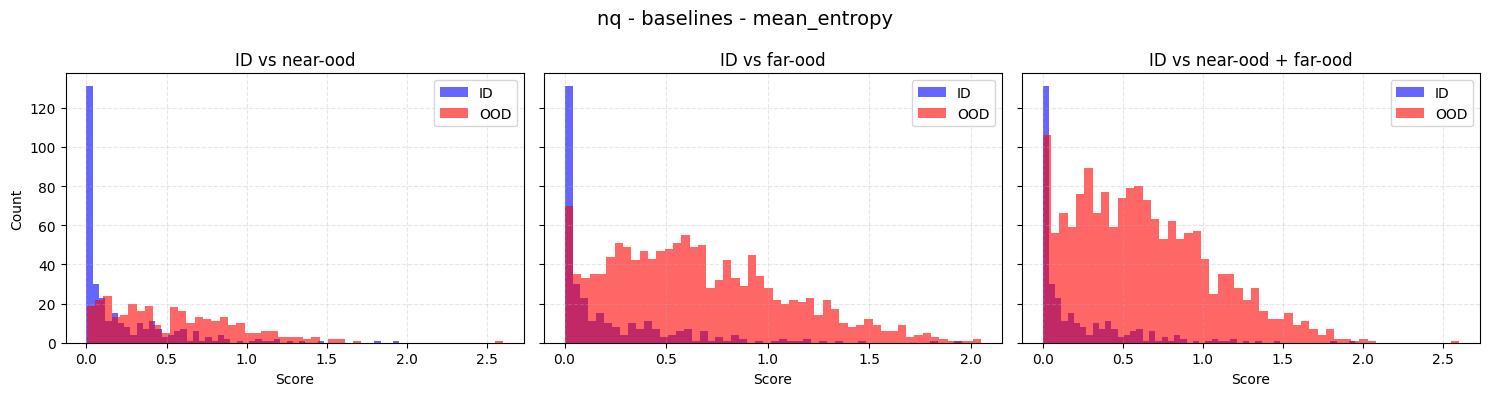

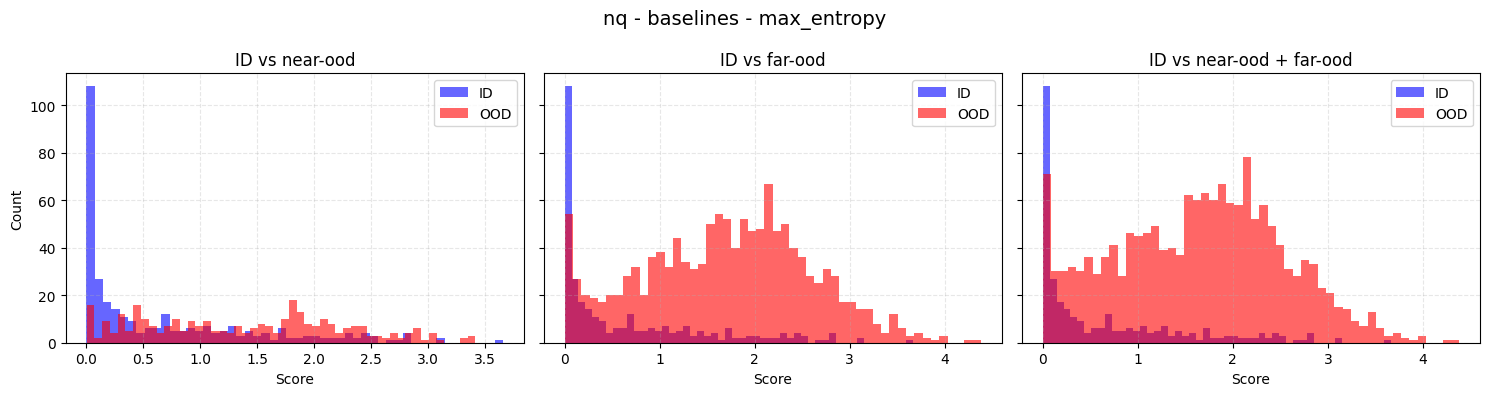

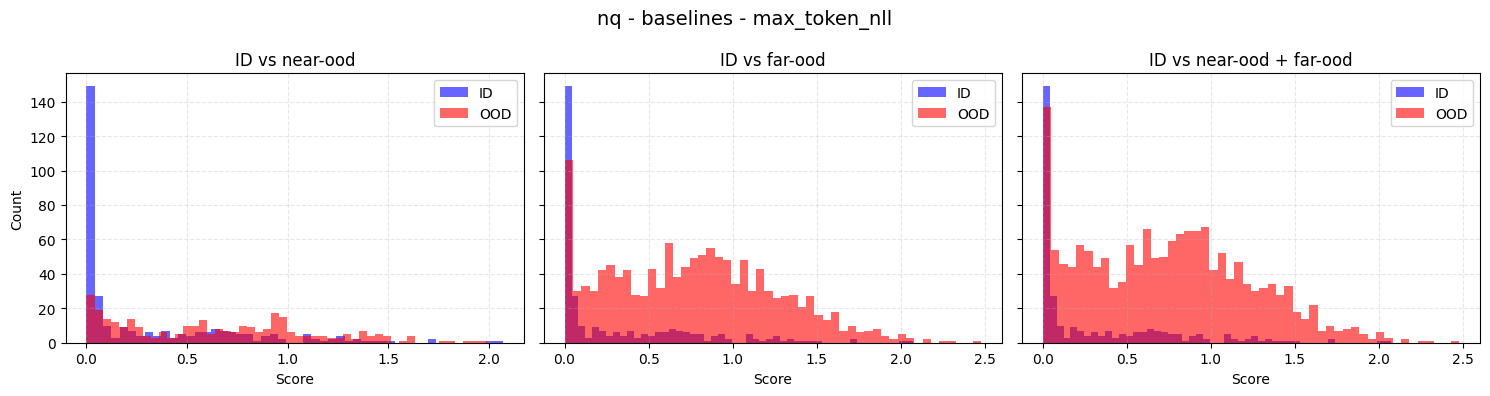

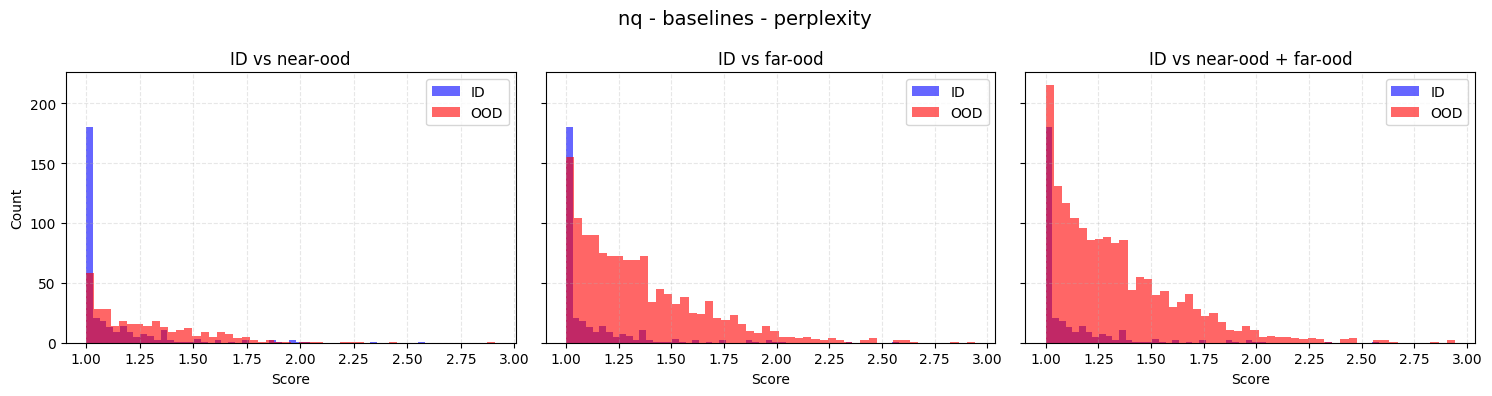

Skipping bertscore in mcdropout-large.jsonl (not found)
Skipping f1 in mcdropout-large.jsonl (not found)
Skipping bertscore in flipout-large.jsonl (not found)
Skipping f1 in flipout-large.jsonl (not found)


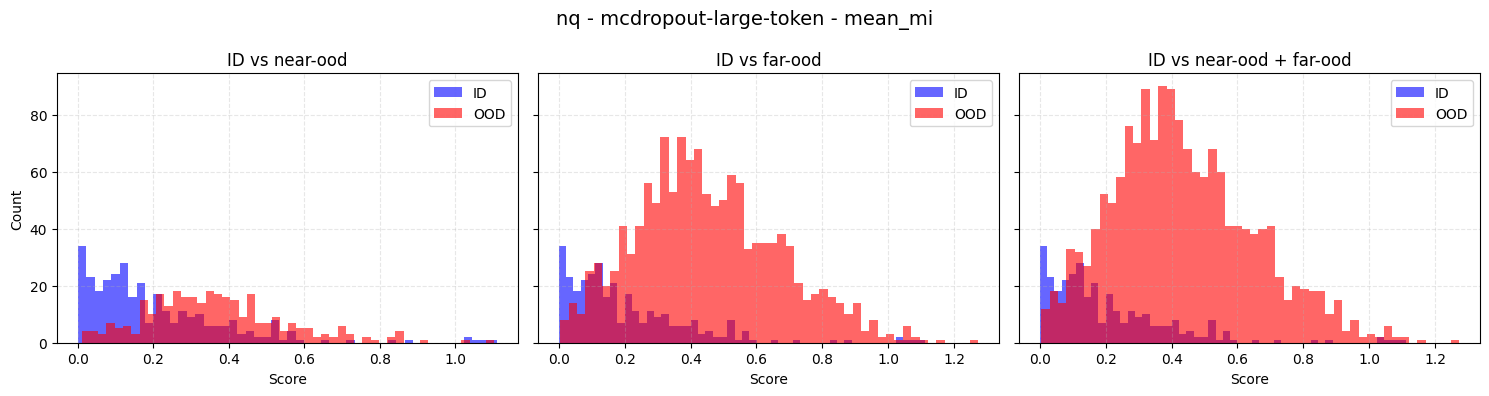

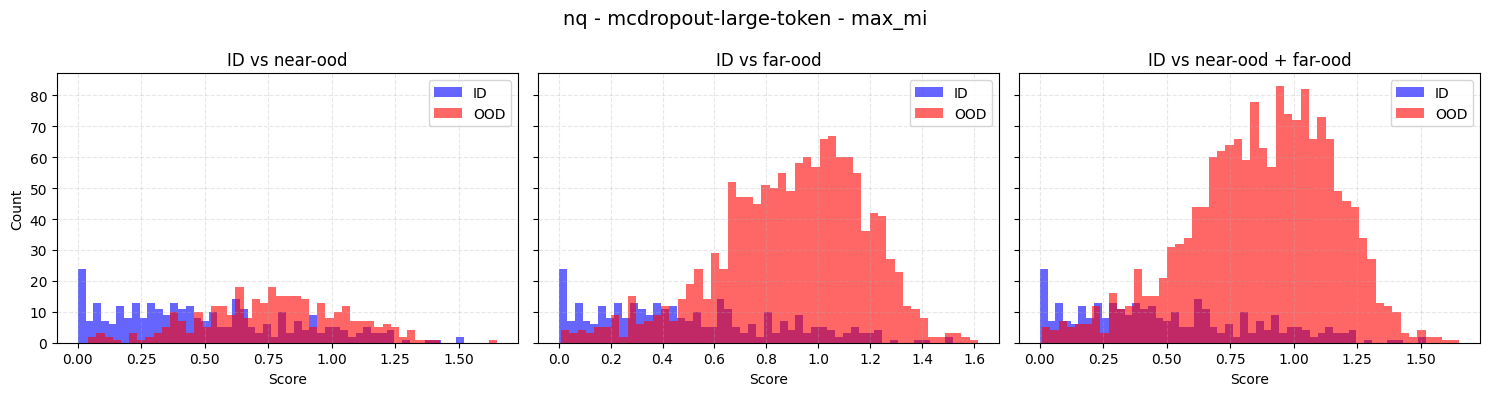

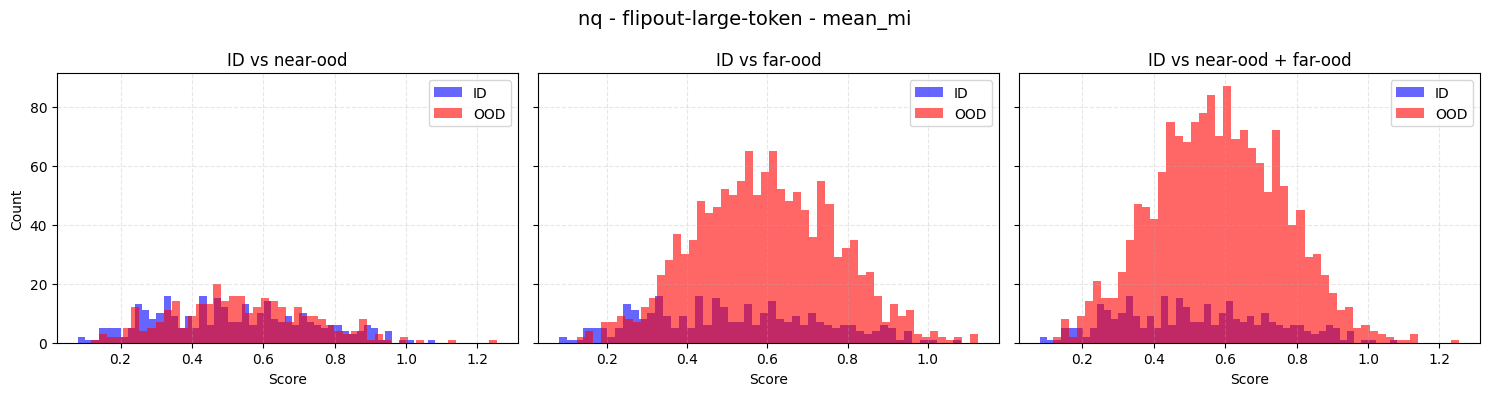

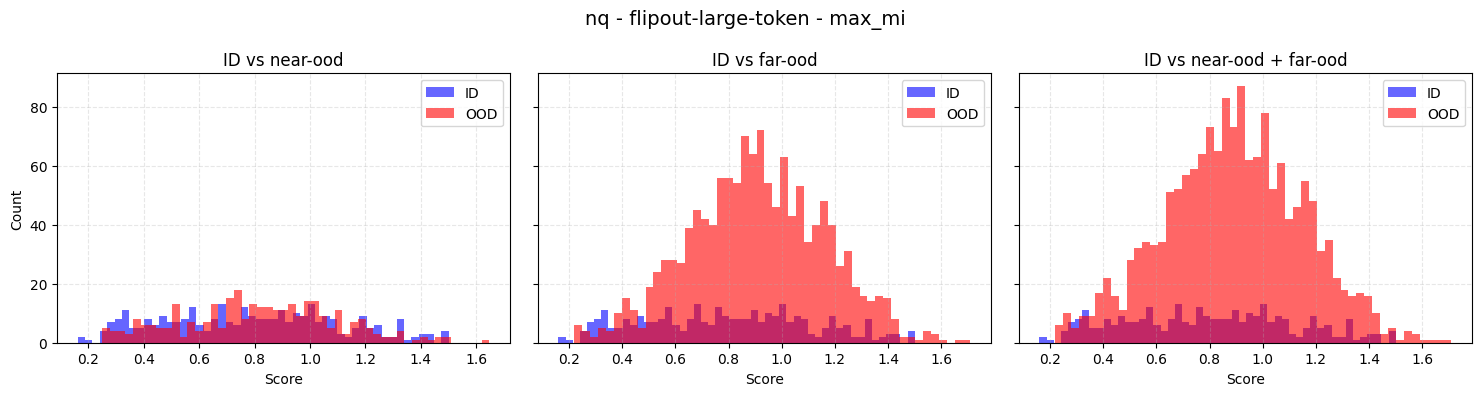

In [ ]:
def view_all_hists(dataset: str) -> None:
    base = Path("../results")
    files_methods = {
        "baselines.jsonl": ["mean_entropy", "max_entropy", "max_token_nll", "perplexity"],
        "mcdropout-large.jsonl": ["bertscore", "f1"],
        "flipout-large.jsonl": ["bertscore", "f1"],
        "mcdropout-large-token.jsonl": ["mean_mi", "max_mi"],
        "flipout-large-token.jsonl": ["mean_mi", "max_mi"],
    }

    for suffix, methods in files_methods.items():
        filepath = base / dataset / suffix
        if not filepath.exists():
            print(f"Skipping {filepath} (not found)")
            continue

        df = pd.read_json(filepath, lines=True)
        model_name = suffix.replace(".jsonl", "")

        for method in methods:
            if method not in df.columns:
                print(f"Skipping {method} in {suffix} (not found)")
                continue

            fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
            id_data = df[df["labels"] == "in"][method].to_numpy()
            splits = (("near-ood",), ("far-ood",), ("near-ood", "far-ood"))

            for idx, cols in enumerate(splits):
                ood_data = df[df["labels"].isin(cols)][method].to_numpy()
                ax[idx].hist(id_data, bins=50, alpha=0.6, color="blue", label="ID")
                ax[idx].hist(ood_data, bins=50, alpha=0.6, color="red", label="OOD")
                ax[idx].set_xlabel("Score")
                ax[idx].set_ylabel("Count" if idx == 0 else "")
                ax[idx].set_title(f"ID vs {' + '.join(cols)}")
                ax[idx].legend()
                ax[idx].grid(alpha=0.3, linestyle="--")

            fig.suptitle(f"{dataset} - {model_name} - {method}", fontsize=14)
            plt.tight_layout()
            # plt.savefig(f"figures/{dataset}_{model_name}_{method}.pdf")
            plt.show()

view_all_hists("webquestions")
view_all_hists("nq")

Removed:
- ROC curves
- EM scores and performance (#correct) per split. using most common answer as hard prediction. including answer normalization.
